In [101]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.integrate import odeint
import matplotlib.animation as animation

# Simple Model

Simple model: Land and ocean.  Land is assumed to have near-zero heat capacity.  Ocean is a two-box model with mixed layer (small heat capacity) and deep ocean (very large heat capacity)

### Forcing

Forcing: take 2xCO2 forcing (assumed to be 3.72 W/m2) and partition such that [forcing_fraction_land] is over land. Can choose between "abrupt" (abruptly double CO2), "1pctCO2" (increase at 1%/year) or "ramp" (increase at 1%/year to doubling, then hold constant.)

In [102]:
def PartitionForcing(forcing_fraction_land = None,typ="abrupt",landfrac=0.29):
    """
    Arguments:
    forcing_fraction_land: amount of forcing over land (default = landfrac for well-mixed)
    typ: type of forcing (abrupt, 1%CO2/year, ramp)
    landfrac: fraction of Earth's surface covered by land
    """
    if forcing_fraction_land is None:
        forcing_fraction_land = landfrac
    oceanfrac = 1.-landfrac
    ### Forcing type ###
    if typ == "abrupt":
        F = lambda t: 3.726 #Double CO2 abruptly; fix for all times
    elif typ == "1pctCO2":
        F = lambda t: 5.35*np.log(1.01)*t #Increase CO2 continuously at 1%/year
    elif typ == "ramp":
        F = lambda t: 5.35*np.log(1.01)*t if t<= 70 else 3.726 #Increase CO2 to doubling; then hold constant
    else:
        print "typ must be one of [abrupt,1pctCO2,ramp]"
        raise TypeError
    FL = lambda t: F(t)*forcing_fraction_land/landfrac
    FO = lambda t: F(t)*(1.-forcing_fraction_land)/oceanfrac
    return FL, FO

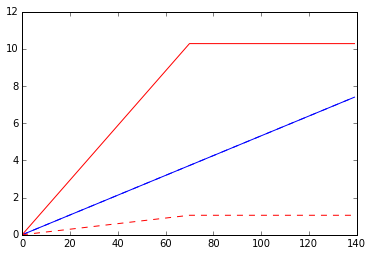

In [103]:
FL,FO=PartitionForcing(.29,typ="1pctCO2")
T = np.arange(140)
plt.plot(T,[FL(t) for t in T],"b")
plt.plot(T,[FO(t) for t in T],"b--")
FL,FO = PartitionForcing(.8,typ="ramp")
plt.plot(T,[FL(t) for t in T],"r")
plt.plot(T,[FO(t) for t in T],"r--")

In [104]:
def vectorfield(w,t,p):
    """
    Arguments:
    w :  vector of the state variables:
        w = [T_land, T_mixedlayer, T_deep]
    t :  time
    p :  vector of the parameters:
        p = [FL,FO, lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac]
    """
    CL = 0.01
    CML = 12.
    CDO = 244.
    FL, FO, lambda_l, lambda_o, alpha_l, alpha_o,gamma, landfrac = p
    T_land, T_mixedlayer, T_deep = w
    f = [1/CL*(FL(t) - lambda_l*T_land + alpha_o/landfrac*T_mixedlayer-alpha_l/landfrac*T_land),\
        1/CML*(FO(t)-lambda_o*T_mixedlayer-alpha_o/(1-landfrac)*T_mixedlayer + alpha_l/(1-landfrac)*T_land-gamma*(T_mixedlayer-T_deep)),\
        1/CDO*gamma*(T_mixedlayer - T_deep)]

    return f
    

In [105]:
def SolveDiffEq(params,show=True,cmap=cm.jet):
    """
    Arguments:
    p :  vector of the parameters:
        p = [FL,FO, lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac]
    """
    
    #Initial conditions
    T_land = 0
    T_mixedlayer = 0
    T_deep = 0


    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6
    stoptime = 500.0
    numpoints = 500

    # Create the time samples for the output of the ODE solver.
    # I use a large number of points, only because I want to make
    # a plot of the solution that looks nice.
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]


    p = params
    w0 = [ T_land, T_mixedlayer, T_deep]
    
    wsol = odeint(vectorfield, w0, t, args=(p,),atol=abserr, rtol=relerr)
    if show:
        plt.plot(t,wsol[:,0],color=cmap(.33),label="T_land",lw=3)
        plt.plot(t,wsol[:,1],color=cmap(.66),label="T_mixedlayer",lw=3)
        plt.plot(t,wsol[:,2],color=cmap(.99),label="T_deepocean",lw=3)
        plt.legend(loc=0)
    return wsol

## Parameters

In [106]:
landfrac = 0.29
typ="ramp"
lambda_l = 3.2
lambda_o = 3.2
alpha_l = 1.62
alpha_o = 2.39
gamma = 2.0

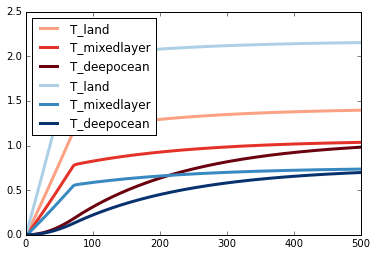

In [107]:
FL_mixed, FO_mixed = PartitionForcing(forcing_fraction_land = 0.29,typ=typ,landfrac = landfrac)
FL_land, FO_land = PartitionForcing(forcing_fraction_land = 1.,typ=typ,landfrac = landfrac)
params_mixed = [FL_mixed,FO_mixed,lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac]
mixed_solution = SolveDiffEq(params_mixed,cmap=cm.Reds)
params_land = [FL_land,FO_land,lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac]
land_solution = SolveDiffEq(params_land,cmap=cm.Blues)

In [108]:
def globalmeanT(wsol,landfrac=0.29):
    return landfrac*wsol[:,0]+(1-landfrac)*wsol[:,1]

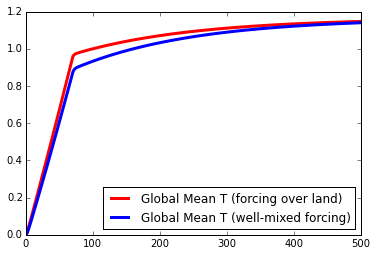

In [109]:
T_avg_land = globalmeanT(land_solution,landfrac = 0.29)
T_avg_mixed = globalmeanT(mixed_solution,landfrac=0.29)
plt.plot(T_avg_land,c="r",lw=3,label="Global Mean T (forcing over land)")
plt.plot(T_avg_mixed,c="b",lw=3,label="Global Mean T (well-mixed forcing)")
plt.legend(loc=0)



In [110]:
class Animator():
    def __init__(self,params,cmap=cm.YlOrRd):
        self.cmap = cmap
        self.params = params
        landfrac = float(self.params[-1])
        self.landfrac=landfrac
        land_depth=.05
        ml_depth=.3
        do_depth=.7

        self.i=0

        self.land = plt.Rectangle((0,0),landfrac,land_depth,edgecolor="w",lw=1,facecolor=self.cmap(self.i))
        self.mixedlayer = plt.Rectangle((landfrac,land_depth-ml_depth),1-landfrac,ml_depth,edgecolor="w",lw=1,facecolor=self.cmap(self.i))
        self.deepocean = plt.Rectangle((landfrac, land_depth-(ml_depth+do_depth)), 1-landfrac,do_depth,edgecolor="w",lw=1,facecolor=self.cmap(self.i))
        self.fig=plt.figure(figsize=(15,15))
        #self.fig=plt.figure()
        self.ax = self.fig.add_subplot(221)
        self.ax.add_patch(self.land)
        self.ax.add_patch(self.mixedlayer)
        self.ax.add_patch(self.deepocean)
  
        

        plt.draw()
        plt.xlim(-.1,1.1)
       # plt.ylim(-1,.1+land_depth)
        plt.ylim(-1,.6)
        plt.xticks([])
        plt.yticks([])
        self.ax2 = self.fig.add_subplot(222)
        self.ax3 = self.fig.add_subplot(223)
        self.ax3.set_title("Ocean Heat Uptake")
        mixedparams = list(params[:])
        FL_mixed, FO_mixed = PartitionForcing(forcing_fraction_land = 0.29,typ="abrupt",landfrac = landfrac)
        
        mixedparams[0]=FL_mixed
        mixedparams[1]=FO_mixed
        
        self.ax4 = self.fig.add_subplot(224)
        self.ax4.set_title("Efficacy")
        
                           
        
        self.mixed_sol = SolveDiffEq(mixedparams,show=False)
   
        self.wsol = SolveDiffEq(params,show=False)
        self.mx = np.max(self.wsol)
        # ODE solver parameters
        stoptime = 70.0
        numpoints = 45
    
        # Create the time samples for the output of the ODE solver.
        # I use a large number of points, only because I want to make
        # a plot of the solution that looks nice.
        self.t = [stoptime * float(pt) / (numpoints - 1) for pt in range(numpoints)]
       
       
    def updatefig(self,*args):
        self.i+=1
        if self.i < self.wsol.shape[0]:
            c = self.wsol[self.i,0]
        #print c
            self.land.set_fc(self.cmap(c/self.mx))
            self.mixedlayer.set_fc(self.cmap(self.wsol[self.i,1]/self.mx))
            self.deepocean.set_fc(self.cmap(self.wsol[self.i,2]/self.mx))
            self.ax2.plot(self.t[:self.i],self.wsol[:self.i,0],color="g",label="T_land",lw=3)
            self.ax2.plot(self.t[:self.i],self.wsol[:self.i,1],color="c",label="T_mixedlayer",lw=3)
            self.ax2.plot(self.t[:self.i],self.wsol[:self.i,2],color="b",label="T_deepocean",lw=3)
            if np.abs(self.i-1.)<0.1:
                self.ax2.legend(loc=0)
            T_mixed = self.landfrac*self.mixed_sol[:,0]+(1-self.landfrac)*self.mixed_sol[:,1]
            T_mixed[0]=1.e20
            T_asym = self.landfrac*self.wsol[:,0]+(1-self.landfrac)*self.wsol[:,1]
            T_asym[0] = 1.e20 #Kludge to prevent instability
            T_asym = np.ma.masked_where(T_asym>1.e10,T_asym)
            T_mixed = np.ma.masked_where(T_mixed>1.e10,T_mixed)
            kappa = float(self.params[2])
            dQ_mixed = (1-self.landfrac)*kappa*(self.mixed_sol[:,1]-self.mixed_sol[:,2])
            dQ_asym =  (1-self.landfrac)*kappa*(self.wsol[:,1]-self.wsol[:,2])
            ECS_Ratio = T_asym/T_mixed * (3.5-dQ_mixed)/(3.5-dQ_asym)
            
            Ratio=T_asym/T_mixed
            #self.ax3.plot(self.t[:self.i],Ratio[:self.i],c=cm.gray(.5),lw=3)
            #self.ax4.plot(self.t[:self.i],ECS_Ratio[:self.i],c=cm.gray(.5),lw=3)
            self.ax3.plot(self.t[:self.i],dQ_mixed[:self.i],c=cm.gray(.5),lw=3,label = "Well-mixed")
            self.ax3.plot(self.t[:self.i],dQ_asym[:self.i],c=cm.Reds(.5),lw=3)
            if np.abs(self.i-1.)<0.1:
                self.ax3.legend(loc=0)
            self.ax4.plot(self.t[:self.i],Ratio[:self.i],c=cm.Blues(.5),lw=3,label="Transient efficacy")
            self.ax4.plot(self.t[:self.i],ECS_Ratio[:self.i],c=cm.Greens(.5),lw=3,label="Equilibrium efficacy")
            if np.abs(self.i-1.)<0.1:
                self.ax4.legend(loc=0)
        
            
                                                   
            



    def Animate(self):
  
        ani = animation.FuncAnimation(self.fig, self.updatefig, interval=50, blit=True)
        return ani
        #w=raw_input("Press any key to close")
        

In [111]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls autoplay>
 <source src="data:{0}">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.m4v') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = 'video/mp4;base64,' + video.encode("base64")
    # prevent figure displayed as a PNG below the animation
    plt.close()
    
    return VIDEO_TAG.format(anim._encoded_video)

animation.Animation._repr_html_ = anim_to_html

RuntimeError: Error writing to file

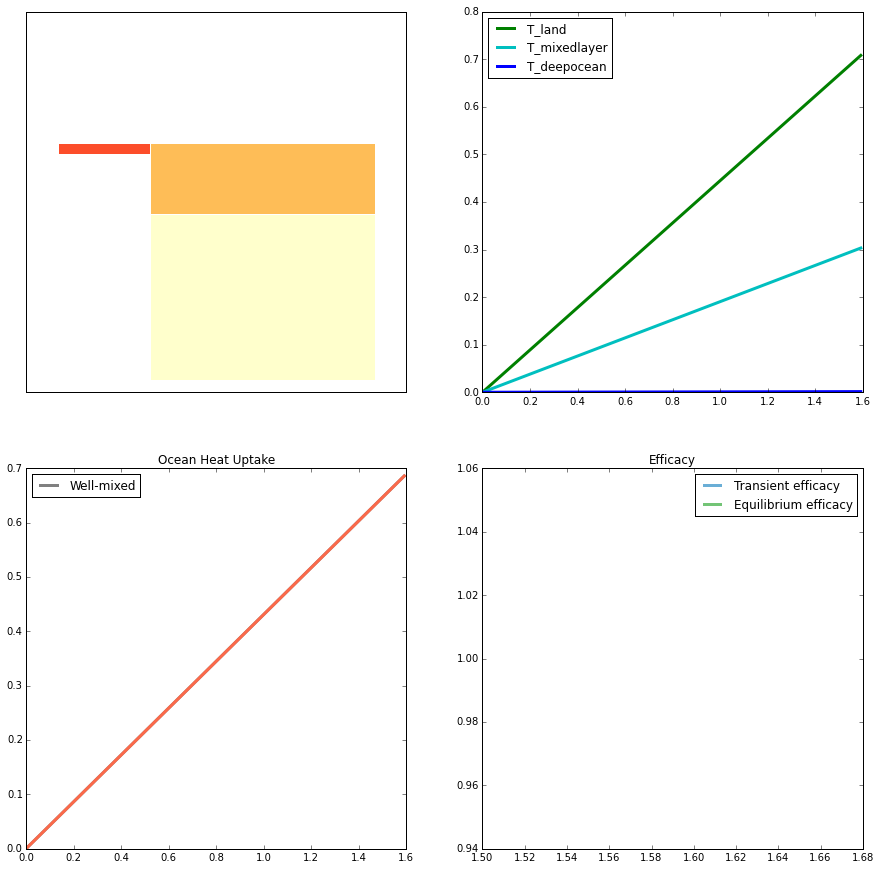

In [112]:

A=Animator(params)
A.Animate()


RuntimeError: Error writing to file

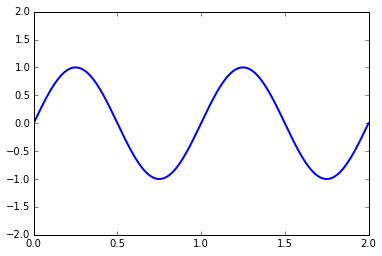

In [113]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)